In [34]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
from igf_data.illumina.samplesheet import SampleSheet

In [3]:
def get_dataframe_from_stats_json(json_file):
  with open(json_file,'r') as json_data:
    json_stats=json.load(json_data)
  
  data1=list()
  runid=json_stats['RunId']  
  total_read=None
  for row in json_stats['ConversionResults']:
    lane=row['LaneNumber']
    total_read=row['TotalClustersPF']
    for sample in row['DemuxResults']:
        sample_id=sample['SampleId']
        number_reads=sample['NumberReads']
        for index in sample['IndexMetrics']:
            index_seq=index['IndexSequence']
            data1.append({'lane':lane,
                          'sample':sample_id,
                          'index':index_seq,
                          'reads':number_reads,
                          'tag':'known',
                          'runid':runid,
                          'total_read':total_read})
  df1=pd.DataFrame(data1)
  df1=df1.sort_values(['reads'],ascending=True)
  
  data2=list()
  for row in json_stats['UnknownBarcodes']:
    lane=row['Lane']
    max_index=10
    index_count=0
    for barcode,count in sorted(row['Barcodes'].items(), key=lambda x: x[1], reverse=True):
        data2.append({'lane':lane,
                      'sample':'undetermined',
                      'index':barcode,
                      'reads':count,
                      'tag':'unknown',
                      'runid':runid,
                      'total_read':total_read})     
        
  df2=pd.DataFrame(data2)
  df=pd.concat([df1,df2])
  df['mapping_ratio']=df['reads'].map(lambda x: x/total_read)
  return df

In [4]:
def generate_pct(x):
    known_read=int(x['known_read'])
    unknown_read=int(x['unknown_read'])
    known_pct=(known_read/(known_read+unknown_read))*100
    x['known_pct']=known_pct
    unknown_pct=(unknown_read/(known_read+unknown_read))*100
    x['unknown_pct']=unknown_pct
    return x

In [51]:
def check_barcode_stats(stats_json, sample_sheet,lane_number):
    stats_df=pd.DataFrame(columns=['index','lane','reads',
                                   'runid','sample','tag',
                                   'total_read','mapping_ratio'])     # define structure for stats df
    
    json_data=get_dataframe_from_stats_json(json_file=stats_json)     # get stats json data for each file
    stats_df=pd.concat([json_data,stats_df])                          # combine all json files 
    
    samplesheet_data=SampleSheet(infile=sample_sheet)
    samplesheet_data.filter_sample_data(condition_key='Lane', \
                                        condition_value=lane_number)  # filter samplesheet for the lane
    all_known_indexes=samplesheet_data.get_indexes()                  # get all known indexes present on the lane
    
    u_stats_df=stats_df.groupby('tag').get_group('unknown')
    k_stats_df=stats_df.groupby('tag').get_group('known')             # separate known and unknown groups
    u_stats_df=u_stats_df[u_stats_df['index'].\
                          isin(all_known_indexes)==False]             # filter all known barcodes 4m unknown
    stats_df=pd.concat([k_stats_df,u_stats_df])                       # merge dataframe back together
    stats_df['log_total_read']=stats_df['total_read'].\
                               map(lambda x: math.log2(x))            # add log2 of total reads in df
        
    summary_df=stats_df.pivot_table(values=['reads'],\
                                    index=['tag','lane','runid'], \
                                    aggfunc=np.sum)                   # create summary df
    
    processed_df=pd.DataFrame(columns=['id','known_read','unknown_read']) # define processed df structure
    
    for rid, rg in summary_df.groupby('runid'):
      for lid, lg in rg.groupby('lane'):
        known_reads=lg.loc['known']['reads'].values[0]
        unknown_reads=lg.loc['unknown']['reads'].values[0]
        runid='{0}_{1}'.format(rid, lid)
        df=pd.DataFrame([{'id':runid,'known_read':known_reads,
                          'unknown_read':unknown_reads}])
        processed_df=pd.concat([df,processed_df])                      # format processed df
        
    processed_df=processed_df.apply(lambda x: generate_pct(x), axis=1) # calculate % of known and unknown barcodes
    return (stats_df, processed_df)

In [77]:
def validate_barcode_stats(raw_df,summary_df,know_barcode_ratio_cutoff=0.8):
    try:
      # check known_pct/unknown_pct
      for runid, grp in summary_df.groupby('id'):
          known_barcode_ratio=grp['known_pct'].values[0]/grp['unknown_pct'].values[0]
          if known_barcode_ratio < know_barcode_ratio_cutoff:
              raise ValueError('{0} failed total barcode check'.format(runid))
          else:
              print('{0} passed total barcode check'.format(runid))
                
      # check for individual barcodes mapping ratios
      for rid, rgrp in raw_df.groupby('runid'):
            for lid,lgrp in rgrp.groupby('lane'):
                known_grp=lgrp.groupby('tag').get_group('known')
                min_known_mpr=known_grp['mapping_ratio'].min()
                unknown_grp=lgrp.groupby('tag').get_group('unknown')
                max_unknown_mpr=unknown_grp['mapping_ratio'].max()
                if min_known_mpr > max_unknown_mpr:
                    print('{0}{1} passed mapping ratio check'.format(rid,lid))
                else:
                    raise ValueError('{0} {1} failed mapping ratio check'.format(rid, lid))
    except:
        raise

In [126]:
def generate_barcode_plots(raw_df,summary_df):
    summary_df_temp=summary_df.set_index('id')
    fig, ax=plt.subplots()
    summary_df_temp[['known_pct','unknown_pct']].plot(ax=ax,kind='bar',color=['blue','orange'],stacked=True)
    plt.show()
    raw_df_tmp=raw_df.set_index('index')
    fig, ax=plt.subplots()
    for gk,gr in raw_df_tmp.groupby('tag'):
      if gk=='known':
        ax.scatter(x=gr['log_total_read'],y=gr['mapping_ratio'],color='green')
      elif gk=='unknown':
        ax.scatter(x=gr['log_total_read'],y=gr['mapping_ratio'],color='blue')
    plt.show()
    raw_df_tmp['log_mapping_ratio']=raw_df_tmp['mapping_ratio'].map(lambda x: math.log(x))
    fig, ax=plt.subplots()
    for gk,gr in raw_df_tmp.groupby('tag'):
      if gk=='known':
        gr['log_mapping_ratio'].plot(ax=ax,kind='kde',color='blue')
      elif gk=='unknown':
        gr['log_mappibng_ratio'].sort_values(ascending=False).head(20).plot(ax=ax,kind='kde',color='orange')
    plt.show()

In [137]:
(stats_df, processed_df)=check_barcode_stats(stats_json='../../test_dir/test5_barcode_stats/atanur_Stats.json',\
                                             sample_sheet='../../test_dir/test5_barcode_stats/HJM5MBBXX.csv',\
                                             lane_number=1)

In [138]:
validate_barcode_stats(raw_df=stats_df,summary_df=processed_df)

170908_K00345_0020_AHJMN5BBXX_6 passed total barcode check
170908_K00345_0020_AHJMN5BBXX6 passed mapping ratio check


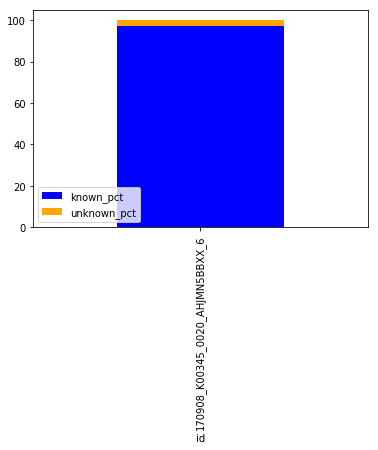

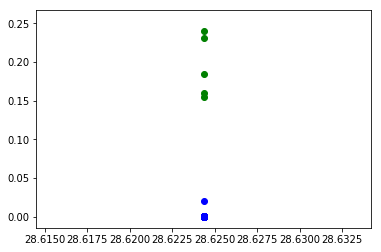

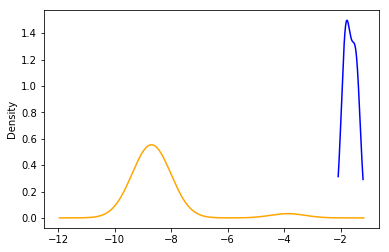

In [139]:
generate_barcode_plots(raw_df=stats_df,summary_df=processed_df)